In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import pickle as pk

import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths

# Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
aisles.size

268

In [7]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
departments.isnull().values.any()

False

In [9]:
print(departments.size)
departments.head(50)

42


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [10]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

In [12]:
orders.size

23947581

The missing values in _orders_ appear to correspond to the date of "previous order", when it happens to be the first one.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
history.isnull().values.any()

False

There are no unexpected NaN values in any of the Instacart datasets.

## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [15]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


In [17]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [18]:
by_dept = {}
for dept in food_depts:
    by_dept[dept] = products_litteral[products_litteral.department==dept]

In [19]:
products_litteral[products_litteral.department=='deli'].head(50)

,product_id,product_name,aisle,department
45210,49,Vegetarian Grain Meat Sausages Italian - 4 CT,tofu meat alternatives,deli
45211,74,Artisan Chick'n & Apple Sausage,tofu meat alternatives,deli
45212,616,Silken Tofu,tofu meat alternatives,deli
45213,731,Wild Mushroom Vegetarian Quarter Loaf,tofu meat alternatives,deli
45214,904,"Tofu, Gluten Free, Garlic Pepper",tofu meat alternatives,deli
45215,1455,Firm Pesto Tofu,tofu meat alternatives,deli
45216,1646,Smoked Ham Style Deli Slices,tofu meat alternatives,deli
45217,2344,Organic SprouTofu Savory Baked Tofu,tofu meat alternatives,deli
45218,2791,Organic SprouTofu Hickory BBQ Smoked Tofu,tofu meat alternatives,deli
45219,3174,Sprouted Tofu Plus Organic Super Firm,tofu meat alternatives,deli


**Dealing with 'missing' values**


In [20]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,missing,missing
42819,440,Crossovers Olive Thyme Almond,missing,missing
42820,472,Fancy Diced Hot Chilies,missing,missing
42821,491,Pompelmo Water,missing,missing
42822,556,Bake & Break Cheese Garlic Loaf,missing,missing


We can see many products don't have any name for the aisle and/or department

In [21]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decide in a first approach to let them in our work dataset, but to treat them carefully. In further steps, we may remove them or find a way to associate them with their correct aisle and department.

In [22]:
#products_litteral = products_litteral.drop(missing.index)

In [23]:
del(products)
del(missing)

In [24]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

In [25]:
orders_products_by_dept = {}
for dept in food_depts:
    orders_products_by_dept[dept] = pd.merge(orders_products, by_dept[dept], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]
    print(orders_products_by_dept[dept].head())

   user_id  product_id  order_id product_name
0       65        5161   3003586  Dried Mango
1       65        5161   1625976  Dried Mango
2       65        5161   2133732  Dried Mango
3       65        5161   1999119  Dried Mango
4       65        5161    225812  Dried Mango
   user_id  product_id  order_id            product_name
0        2          23    788338  Organic Turkey Burgers
1      434          23   1073729  Organic Turkey Burgers
2      643          23   1554027  Organic Turkey Burgers
3      704          23   2376164  Organic Turkey Burgers
4      968          23   1654363  Organic Turkey Burgers
   user_id  product_id  order_id         product_name
0        1       12427   2539329  Original Beef Jerky
1        1       12427   2398795  Original Beef Jerky
2        1       12427    473747  Original Beef Jerky
3        1       12427   2254736  Original Beef Jerky
4        1       12427    431534  Original Beef Jerky
   user_id  product_id  order_id product_name
0        1  

In [26]:
del(orders_products)

In [27]:
orders_users_by_dept = {}
for dept in food_depts:
    orders_users_by_dept[dept] = orders_products_by_dept[dept].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    print(orders_users_by_dept[dept].head())

                                        nb_orders
user_id product_id product_name                  
65      5161       Dried Mango                 10
68      22260      Organic Rolled Oats          2
138     1000       Apricots                     1
140     1000       Apricots                     5
149     30365      Vegetable Chips              2
                                                      nb_orders
user_id product_id product_name                                
2       23         Organic Turkey Burgers                     1
6       38293      Ground Turkey Breast                       2
7       13198      85% Lean Ground Beef                       8
9       7952       Chicken & Apple Breakfast Sausage          1
10      5646       Organic Turkey Bacon                       1
                                                                       nb_orders
user_id product_id product_name                                                 
1       10258      Pistachios           

In [28]:
del(orders_products_by_dept)

In [ ]:
# ne pas run a partir de la

In [45]:
graphs = {dept: nx.Graph() for dept in food_depts}
for dept in food_depts:
    for prod in by_dept[dept]['product_id'].unique():
        graphs[dept].add_node(prod, bipartite=0)
    for user in orders.user_id.unique():
        graphs[dept].add_node(-user, bipartite=1)


In [47]:
for dept in food_depts:
    for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
        graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])
    print('Done', dept)

Done produce
Done bakery
Done deli
Done breakfast
Done alcohol
Done pantry
Done international


In [48]:
dept = 'produce'
graphs[dept] = nx.Graph()
for prod in by_dept[dept]['product_id'].unique():
    graphs[dept].add_node(prod, bipartite=0)
for user in orders.user_id.unique():
    graphs[dept].add_node(-user, bipartite=1)
for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
    graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])

In [41]:
food_depts

['bulk',
 'meat seafood',
 'snacks',
 'beverages',
 'frozen',
 'dairy eggs',
 'canned goods',
 'dry goods pasta',
 'produce',
 'bakery',
 'deli',
 'breakfast',
 'alcohol',
 'pantry',
 'international']

In [55]:
with open('user_and_prod_graphs.pk', 'wb') as file:
    pk.dump(graphs, file)

In [56]:
with open('user_and_prod_graphs.pk', 'rb') as file:
    graphs2 = pk.load(file)

In [50]:
nx.info(graphs['produce'])

'Name: \nType: Graph\nNumber of nodes: 207893\nNumber of edges: 3318581\nAverage degree:  31.9259'

In [57]:
nx.info(graphs2['produce'])

'Name: \nType: Graph\nNumber of nodes: 207893\nNumber of edges: 3318581\nAverage degree:  31.9259'

In [58]:
del(graphs2)

In [ ]:
#nx.draw_spring(graphs['pantry'], with_labels=True,  alpha = 0.8)

In [51]:
# project on products
def my_weight(G, u, v):
    w = 0
    n = 0
    for nbr in set(G[u]) & set(G[v]):
        n += 1
        w += (G[u][nbr].get('weight', 1) + G[v][nbr].get('weight', 1)) / 2
    return w * np.sqrt(n)

In [64]:
prod_graphs = {}
for dept in food_depts:
    print('\n', dept)
    prod_graphs[dept] = bipartite.generic_weighted_projected_graph(graphs[dept], {n for n, d in graphs[dept].nodes(data=True) if d['bipartite']==0}, weight_function=my_weight)
    print(nx.info(prod_graphs[dept]))
    del(graphs[dept])


 bulk
Name: 
Type: Graph
Number of nodes: 38
Number of edges: 326
Average degree:  17.1579

 meat seafood
Name: 
Type: Graph
Number of nodes: 907
Number of edges: 59735
Average degree: 131.7200

 snacks
Name: 
Type: Graph
Number of nodes: 6264
Number of edges: 2222945
Average degree: 709.7526

 beverages
Name: 
Type: Graph
Number of nodes: 4365
Number of edges: 1075824
Average degree: 492.9320

 frozen
Name: 
Type: Graph
Number of nodes: 4007
Number of edges: 1266039
Average degree: 631.9137

 dairy eggs
Name: 
Type: Graph
Number of nodes: 3449
Number of edges: 1280520
Average degree: 742.5457

 canned goods
Name: 
Type: Graph
Number of nodes: 2092
Number of edges: 311710
Average degree: 298.0019

 dry goods pasta
Name: 
Type: Graph
Number of nodes: 1858
Number of edges: 238655
Average degree: 256.8945

 produce
Name: 
Type: Graph
Number of nodes: 1684
Number of edges: 517944
Average degree: 615.1354

 bakery
Name: 
Type: Graph
Number of nodes: 1516
Number of edges: 156031
Average deg

In [65]:
with open('prod_graphs.pk', 'wb') as file:
    pk.dump(prod_graphs, file)


 bulk

 meat seafood


ArpackNoConvergence: ARPACK error -1: No convergence (9071 iterations, 0/3 eigenvectors converged)

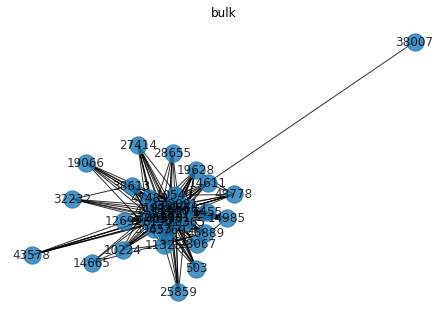

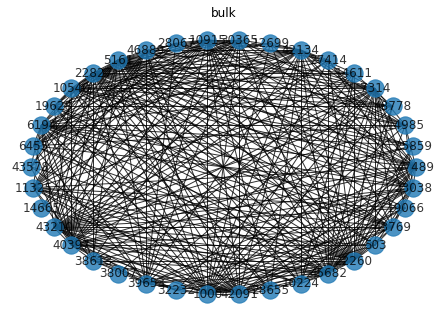

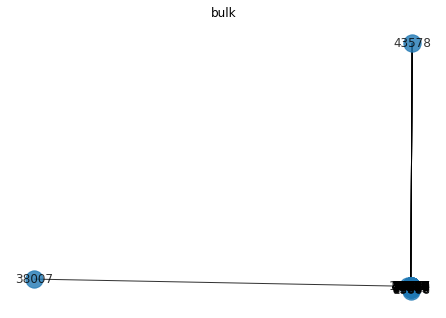

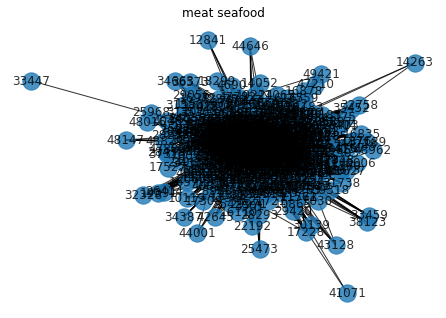

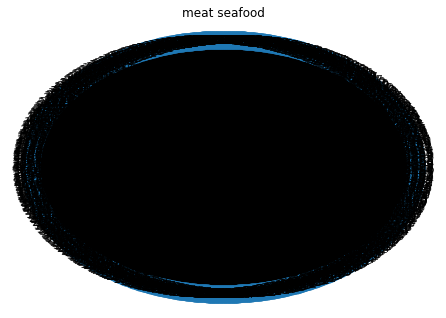

<Figure size 432x288 with 0 Axes>

In [69]:
for dept in food_depts[:2]:
    print('\n', dept)
    #plt.figure()
    #nx.draw_spring(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    #plt.title(dept)
    plt.figure()
    nx.draw(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    plt.title(dept)
    plt.figure()
    nx.draw_circular(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    plt.title(dept)
    plt.figure()
    nx.draw_spectral(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    plt.title(dept)


In [87]:
for dept in food_depts:
    lst = sorted(components.connected_components(prod_graphs[dept]), key=len, reverse=True)
    print(dept, ':')
    for g in lst[1:]:
        for p in g:
            print(by_dept[dept][by_dept[dept].product_id==p]['product_name'])
    print('\n')

bulk :


meat seafood :


snacks :
447    Chocolate Go Bites
Name: product_name, dtype: object


beverages :
14338    Pure Squeezed  Lemonade
Name: product_name, dtype: object
14299    Single Barrel Kentucky Straight Bourbon Whiskey
Name: product_name, dtype: object


frozen :


dairy eggs :
27931    Wasabi Cheddar Spreadable Cheese
Name: product_name, dtype: object


canned goods :


dry goods pasta :
36803    Microwavable Triple Cheese Macaroni & Cheese
Name: product_name, dtype: object


produce :


bakery :
48478    Multigrain Croissants
Name: product_name, dtype: object


deli :


breakfast :
38861    Protein Granola Apple Crisp
Name: product_name, dtype: object


alcohol :
47573    Indian Wells Merlot
Name: product_name, dtype: object
47348    Hennepin Farmhouse Ale
Name: product_name, dtype: object
47257    Gluten Free Gold Lager
Name: product_name, dtype: object


pantry :
8574    Unpeeled Apricot Halves in Heavy Syrup
Name: product_name, dtype: object


international :
44570  

In [91]:
dept = 'bulk'
edges = [(u, v, d['weight']) for (u, v, d) in prod_graphs[dept].edges(data=True)]
#np.mean([(u, v) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] > 0.5])
edges_test = set()
for (u,v,w) in edges:
    if (v,u) in edges_test:
        print('double')
        break
    else:
        edges_test.add((u,v))

In [92]:
edge_weights = [d['weight'] for (u, v, d) in prod_graphs[dept].edges(data=True)]

array([162.,  45.,  14.,  33.,  16.,  10.,  18.,   7.,   3.,   6.,   0.,
         0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   1.,
         1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.])

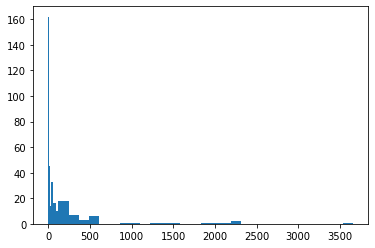

In [97]:
plt.hist(edge_weights, bins=[0,10,20,30,60,90,120,2.44708829e+02, 3.66563243e+02,
        4.88417658e+02, 6.10272072e+02, 7.32126487e+02, 8.53980901e+02,
        9.75835315e+02, 1.09768973e+03, 1.21954414e+03, 1.34139856e+03,
        1.46325297e+03, 1.58510739e+03, 1.70696180e+03, 1.82881622e+03,
        1.95067063e+03, 2.07252505e+03, 2.19437946e+03, 2.31623387e+03,
        2.43808829e+03, 2.55994270e+03, 2.68179712e+03, 2.80365153e+03,
        2.92550595e+03, 3.04736036e+03, 3.16921478e+03, 3.29106919e+03,
        3.41292360e+03, 3.53477802e+03, 3.65663243e+03])[0]

In [101]:
thresholded = nx.Graph(((u, v, d) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] >= 10))

In [102]:
print(nx.info(prod_graphs[dept]))
print(nx.info(thresholded))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 326
Average degree:  17.1579
Name: 
Type: Graph
Number of nodes: 33
Number of edges: 164
Average degree:   9.9394


In [103]:
[len(c) for c in sorted(components.connected_components(thresholded), key=len, reverse=True)]

[33]

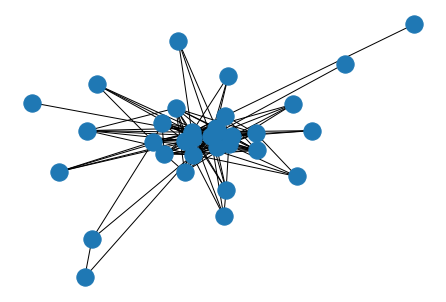

In [109]:
nx.draw(thresholded)

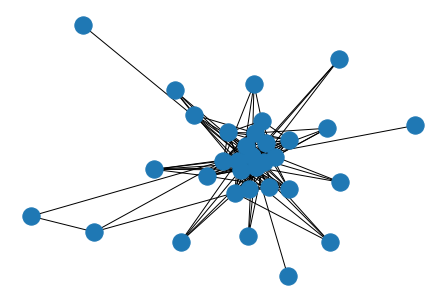

In [163]:
nx.draw_spring(thresholded)

In [113]:
shortest_paths.generic.average_shortest_path_length(thresholded)

1.7367424242424243

In [116]:
sp = shortest_paths.dense.floyd_warshall(thresholded)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
#print(max(sp.values()), min(sp.values()))

{(47489, 47489): 0,
 (47489, 40397): 34.45302614079072,
 (47489, 42134): 30.00657780874821,
 (47489, 10915): 42.0,
 (47489, 5161): 42.0,
 (47489, 22827): 21.166010488516726,
 (47489, 10540): 11.0,
 (47489, 42091): 19.918584287042087,
 (47489, 6194): 19.00657780874821,
 (47489, 22260): 64.57763793828883,
 (47489, 25859): 52.60660171779821,
 (47489, 14985): 54.37490770683399,
 (47489, 1000): 39.65247584249853,
 (47489, 6455): 41.00657780874821,
 (47489, 48778): 89.62352359916264,
 (47489, 7314): 29.0,
 (47489, 43210): 37.856406460551014,
 (47489, 28067): 39.0,
 (47489, 39653): 36.68909411829051,
 (47489, 45682): 48.0,
 (47489, 11325): 33.14871343247916,
 (47489, 23038): 22.31370849898476,
 (47489, 14611): 24.0,
 (47489, 14665): 44.85582021366571,
 (47489, 12699): 36.17011495953578,
 (47489, 10224): 51.00657780874821,
 (47489, 43769): 48.98746799453936,
 (47489, 30365): 45.89934640057524,
 (47489, 46889): 48.856406460551014,
 (47489, 19628): 52.0,
 (47489, 38613): 54.99038105676658,
 (474

In [167]:
thresholded_inv_edges = []
for (u, v, d) in prod_graphs[dept].edges(data=True):
    if d['weight'] >= 10:
        nd = d.copy()
        nd['weight'] = 1. / d['weight']
        thresholded_inv_edges.append((u,v,nd))
thresholded_inv = nx.Graph(thresholded_inv_edges)
print(nx.info(thresholded_inv))

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 164
Average degree:   9.9394


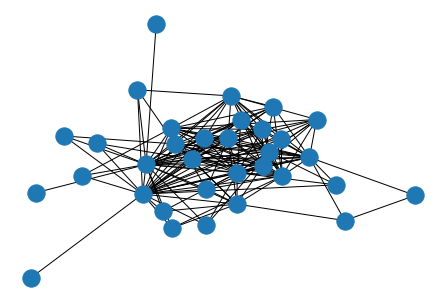

In [169]:
nx.draw_spring(thresholded_inv)

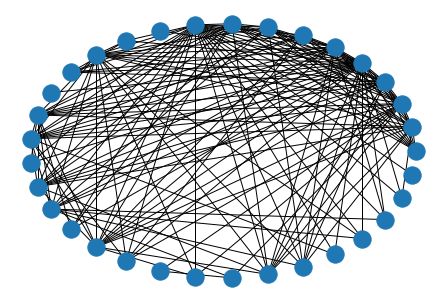

In [170]:
nx.draw_circular(thresholded_inv)

In [174]:
shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight')

0.032407449099350484

In [172]:
sp = shortest_paths.dense.floyd_warshall(thresholded_inv)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
sp2

{(47489, 47489): 0,
 (47489, 40397): 0.005401713433452273,
 (47489, 42134): 0.006066459185822916,
 (47489, 10915): 0.005596017712275927,
 (47489, 5161): 0.005230869367873795,
 (47489, 22827): 0.005480069932254269,
 (47489, 10540): 0.008978657944204983,
 (47489, 42091): 0.007912639384925499,
 (47489, 6194): 0.0058744860171745655,
 (47489, 22260): 0.00494970663339455,
 (47489, 25859): 0.09951177352608012,
 (47489, 14985): 0.034682817723384926,
 (47489, 1000): 0.005682844463306574,
 (47489, 6455): 0.022490415368248563,
 (47489, 48778): 0.026228895646164194,
 (47489, 7314): 0.005223182302148628,
 (47489, 43210): 0.0053818734403199685,
 (47489, 28067): 0.017988628444869516,
 (47489, 39653): 0.00756862063778917,
 (47489, 45682): 0.007142640947298458,
 (47489, 11325): 0.015170430178403487,
 (47489, 23038): 0.00756862063778917,
 (47489, 14611): 0.028519932672946134,
 (47489, 14665): 0.07340996215597029,
 (47489, 12699): 0.0200700136876117,
 (47489, 10224): 0.05368550680487053,
 (47489, 43769):

In [203]:
thresholded_higher = nx.Graph(((bulk_map[u], bulk_map[v], d) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] >= 30))

In [204]:
print(nx.info(prod_graphs[dept]))
print(nx.info(thresholded_higher))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 326
Average degree:  17.1579
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 105
Average degree:   7.5000


In [205]:
[len(c) for c in sorted(components.connected_components(thresholded_higher), key=len, reverse=True)]

[28]

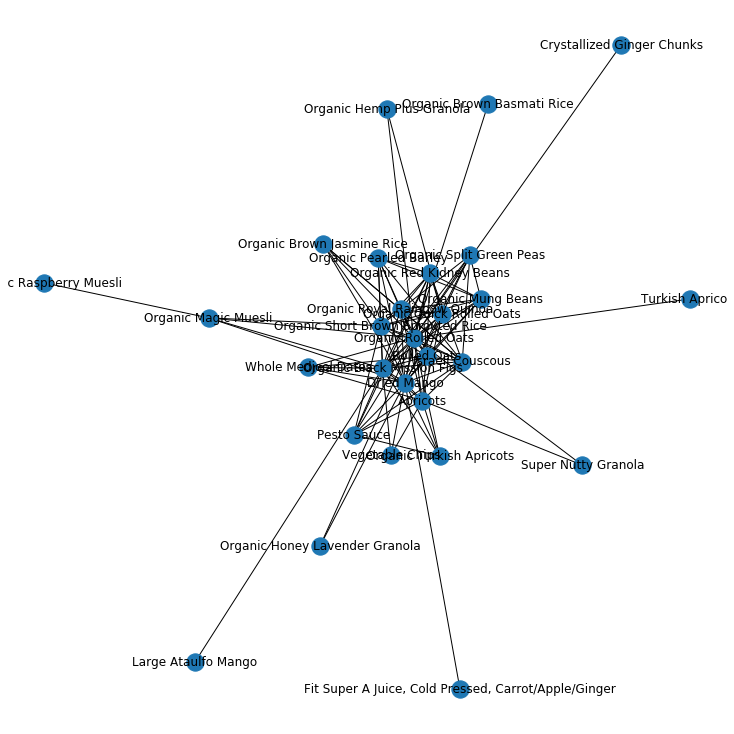

In [207]:
plt.figure(figsize=(10,10))
nx.draw(thresholded_higher, with_labels=True)

In [209]:
for node in thresholded:
    if bulk_map[node] not in thresholded_higher:
        print(bulk_map[node])
print()
for node in prod_graphs[dept]:
    if bulk_map[node] not in thresholded_higher:
        print(bulk_map[node])

Cranberry Beans
Organic White Popcorn
Organic Hunza Golden Raisins
Organic Blueberries Package
Wild Rice Blend

Cranberry Beans
Organic Emmer Farro
Organic Blueberries Package
Madagascar Pink Rice
Organic White Popcorn
Naturally Sweet Plantain Chips
Organic Roasted Buckwheat (Kasha)
Organic Hunza Golden Raisins
Wild Rice Blend
Organic Wheat Bran


In [191]:
by_dept['bulk']

,product_id,product_name,aisle,department
49650,503,Wild Rice Blend,bulk grains rice dried goods,bulk
49651,6194,Organic Red Kidney Beans,bulk grains rice dried goods,bulk
49652,6455,Organic Magic Muesli,bulk grains rice dried goods,bulk
49653,7314,Organic Quick Rolled Oats,bulk grains rice dried goods,bulk
49654,10915,Organic Short Brown Sprouted Rice,bulk grains rice dried goods,bulk
49655,11325,Organic Hemp Plus Granola,bulk grains rice dried goods,bulk
49656,12699,Super Nutty Granola,bulk grains rice dried goods,bulk
49657,14985,Organic Raspberry Muesli,bulk grains rice dried goods,bulk
49658,19066,Organic Wheat Bran,bulk grains rice dried goods,bulk
49659,22260,Organic Rolled Oats,bulk grains rice dried goods,bulk


In [194]:
bulk_map = {}
for index, row in by_dept['bulk'].iterrows():
    bulk_map[row.product_id] = row.product_name

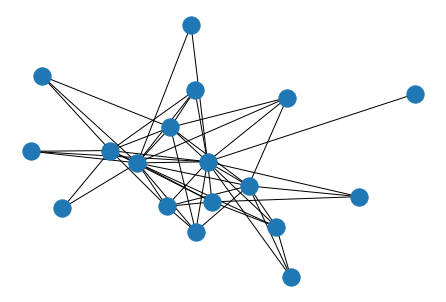

In [188]:
nx.draw_spring(thresholded_higher)

In [189]:
shortest_paths.generic.average_shortest_path_length(thresholded_higher)

1.7058823529411764

In [116]:
sp = shortest_paths.dense.floyd_warshall(thresholded_higher)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
#print(max(sp.values()), min(sp.values()))

{(47489, 47489): 0,
 (47489, 40397): 34.45302614079072,
 (47489, 42134): 30.00657780874821,
 (47489, 10915): 42.0,
 (47489, 5161): 42.0,
 (47489, 22827): 21.166010488516726,
 (47489, 10540): 11.0,
 (47489, 42091): 19.918584287042087,
 (47489, 6194): 19.00657780874821,
 (47489, 22260): 64.57763793828883,
 (47489, 25859): 52.60660171779821,
 (47489, 14985): 54.37490770683399,
 (47489, 1000): 39.65247584249853,
 (47489, 6455): 41.00657780874821,
 (47489, 48778): 89.62352359916264,
 (47489, 7314): 29.0,
 (47489, 43210): 37.856406460551014,
 (47489, 28067): 39.0,
 (47489, 39653): 36.68909411829051,
 (47489, 45682): 48.0,
 (47489, 11325): 33.14871343247916,
 (47489, 23038): 22.31370849898476,
 (47489, 14611): 24.0,
 (47489, 14665): 44.85582021366571,
 (47489, 12699): 36.17011495953578,
 (47489, 10224): 51.00657780874821,
 (47489, 43769): 48.98746799453936,
 (47489, 30365): 45.89934640057524,
 (47489, 46889): 48.856406460551014,
 (47489, 19628): 52.0,
 (47489, 38613): 54.99038105676658,
 (474

In [167]:
thresholded_inv_edges = []
for (u, v, d) in prod_graphs[dept].edges(data=True):
    if d['weight'] >= 10:
        nd = d.copy()
        nd['weight'] = 1. / d['weight']
        thresholded_inv_edges.append((u,v,nd))
thresholded_inv = nx.Graph(thresholded_inv_edges)
print(nx.info(thresholded_inv))

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 164
Average degree:   9.9394


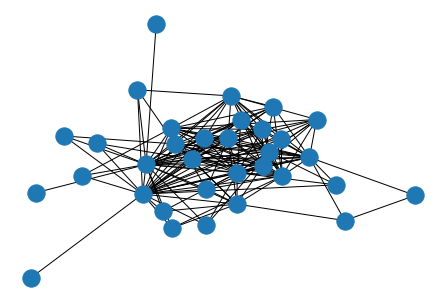

In [169]:
nx.draw_spring(thresholded_inv)

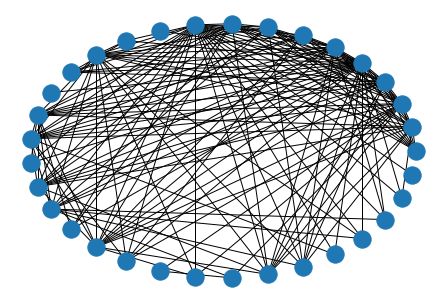

In [170]:
nx.draw_circular(thresholded_inv)

In [174]:
shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight')

0.032407449099350484

In [172]:
sp = shortest_paths.dense.floyd_warshall(thresholded_inv)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
sp2

{(47489, 47489): 0,
 (47489, 40397): 0.005401713433452273,
 (47489, 42134): 0.006066459185822916,
 (47489, 10915): 0.005596017712275927,
 (47489, 5161): 0.005230869367873795,
 (47489, 22827): 0.005480069932254269,
 (47489, 10540): 0.008978657944204983,
 (47489, 42091): 0.007912639384925499,
 (47489, 6194): 0.0058744860171745655,
 (47489, 22260): 0.00494970663339455,
 (47489, 25859): 0.09951177352608012,
 (47489, 14985): 0.034682817723384926,
 (47489, 1000): 0.005682844463306574,
 (47489, 6455): 0.022490415368248563,
 (47489, 48778): 0.026228895646164194,
 (47489, 7314): 0.005223182302148628,
 (47489, 43210): 0.0053818734403199685,
 (47489, 28067): 0.017988628444869516,
 (47489, 39653): 0.00756862063778917,
 (47489, 45682): 0.007142640947298458,
 (47489, 11325): 0.015170430178403487,
 (47489, 23038): 0.00756862063778917,
 (47489, 14611): 0.028519932672946134,
 (47489, 14665): 0.07340996215597029,
 (47489, 12699): 0.0200700136876117,
 (47489, 10224): 0.05368550680487053,
 (47489, 43769):

In [210]:
products_litteral[products_litteral.aisle == 'packaged produce'].head(50)

,product_id,product_name,aisle,department


In [177]:
products_litteral[products_litteral.aisle == 'packaged vegetables fruits'].head(50)

,product_id,product_name,aisle,department
41129,31,White Pearl Onions,packaged vegetables fruits,produce
41130,43,Organic Clementines,packaged vegetables fruits,produce
41131,66,European Style Spring Mix,packaged vegetables fruits,produce
41132,89,Yogurt Fruit Dip Sliced Apples,packaged vegetables fruits,produce
41133,120,Cauliflower Florettes,packaged vegetables fruits,produce
41134,142,Arugula Salad,packaged vegetables fruits,produce
41135,343,Organic Whole Peeled Baby Carrots,packaged vegetables fruits,produce
41136,347,"Vegetable Salad Kit, Sweet Kale",packaged vegetables fruits,produce
41137,364,Greener Selection Salad,packaged vegetables fruits,produce
41138,380,Clementine Bag,packaged vegetables fruits,produce


In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


In [ ]:
# run a partir d'ici

## Look inside the snacks department

In [29]:
orders_users_by_dept['snacks'].head()

nb_orders
user_id product_id product_name                                                 
1       10258      Pistachios                                                  9
        12427      Original Beef Jerky                                        10
        26088      Aged White Cheddar Popcorn                                  2
        39657      Milk Chocolate Almonds                                      1
2       5322       Gluten Free Dark Chocolate Chunk Chewy with a C...          1

In [30]:
snacks_orders_users = orders_users_by_dept['snacks'].reset_index()
snacks_orders_users.head(8)

,user_id,product_id,product_name,nb_orders
0,1,10258,Pistachios,9
1,1,12427,Original Beef Jerky,10
2,1,26088,Aged White Cheddar Popcorn,2
3,1,39657,Milk Chocolate Almonds,1
4,2,5322,Gluten Free Dark Chocolate Chunk Chewy with a ...,1
5,2,8296,OG Sesame Tamari Rice Cake Organic Rice Cakes,1
6,2,8479,Original Black Box Tablewater Cracker,1
7,2,13742,Organic Coconut Almond Peanut,1


In [33]:
import pickle
with open('users_cluster.pk', 'rb') as f:
    users_cluster = pickle.load(f)

In [31]:
orders_matrix = snacks_orders_users.pivot(index='user_id', columns='product_name', values='nb_orders')
orders_matrix.head()

product_name,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,100 Calorie Per Bag Popcorn,100 Calorie Healthy Pop Butter 1.2 Oz Mini Bags Microwave Pop Corn,100 Calorie Healthy Pop Butter Microwave Pop Corn,100 Calorie Healthy Pop Kettle Corn Microwave Pop Corn,100 Calorie Mini Bag Butter Microwave Popcorn,100 Calorie Premium Microwave Butter Popcorn,100 Calorie Pretzels Packs,100 Calorie Right Bites Cheez It Snack Mix,...,"\""Mokaccino\"" Milk + Blue Bottle Coffee Chocolate",eat your vegetables Vegetable Chips Sour Cream & Onion,of Hanover 100 Calorie Pretzels Mini,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
orders_matrix = orders_matrix.fillna(value=0)

In [34]:
# fill in other users (those who did not buy any snack)
#for user_id in set(range(len(users_cluster))).difference(set(orders_matrix.index)):
#    orders_matrix.loc[user_id] = [0. for _ in range(len(orders_matrix.columns))]

In [34]:
orders_by_cluster = {}
for i in range(5):
    orders_by_cluster[i] = orders_matrix.loc[[j+1 for j in range(len(users_cluster)) if users_cluster[j] == i]]
    orders_by_cluster[i].to_pickle('orders_by_cluster_{}'.format(i))

/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


OSError: [Errno 28] No space left on device

In [ ]:
# fill in other users (those who did not buy any snack)
#for i in range(5):
for user_id_minus_one, cl in enumerate(users_cluster):
    if user_id_minus_one+1 not in orders_by_cluster[cl]:
        orders_by_cluster[cl].loc[user_id_minus_one+1] = [0. for _ in range(len(orders_matrix.columns))]

In [35]:
# run jusque là

In [37]:
from scipy.stats import f_oneway, mannwhitneyu, kruskal

In [39]:
for prod, vals in oorders_by_cluster[0].iteritems():
    
    #f_oneway(orders_matrix[orders_matrix.cluster==])
    break

user_id
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
206204    0.0
206206    0.0
206207    0.0
206208    0.0
206209    0.0
Name: 1 Apple + 1 Mango Fruit Bar, Length: 174219, dtype: float64


In [35]:
these_users_cluster = [users_cluster[i-1] for i in orders_matrix.index]

In [39]:
for prod, vals in orders_matrix.iteritems():
    print(vals)
    #f_oneway(orders_matrix[orders_matrix.cluster==])
    break

user_id
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
206204    0.0
206206    0.0
206207    0.0
206208    0.0
206209    0.0
Name: 1 Apple + 1 Mango Fruit Bar, Length: 174219, dtype: float64


# Basic Statistical analysis

A first way to get familiar with the data we have to treat is to derive basic statistics between features. In this part, we do so by joining our 5 datasets and ploting distributions.

### Number of products per Aisle and Department (products diversity)

We first visualize the products per aisle and per department to detect any inconsistency

In [18]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)
per_dpt.columns=['COUNT']

Text(0, 0.5, 'Departments')

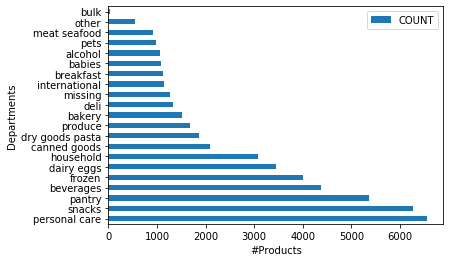

In [19]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [20]:
per_dpt.head()

,COUNT
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


The 'personal care' department has the largest choice of products, just followed by the 'snacks' one.

In [21]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)
per_aisle.columns=['COUNT']


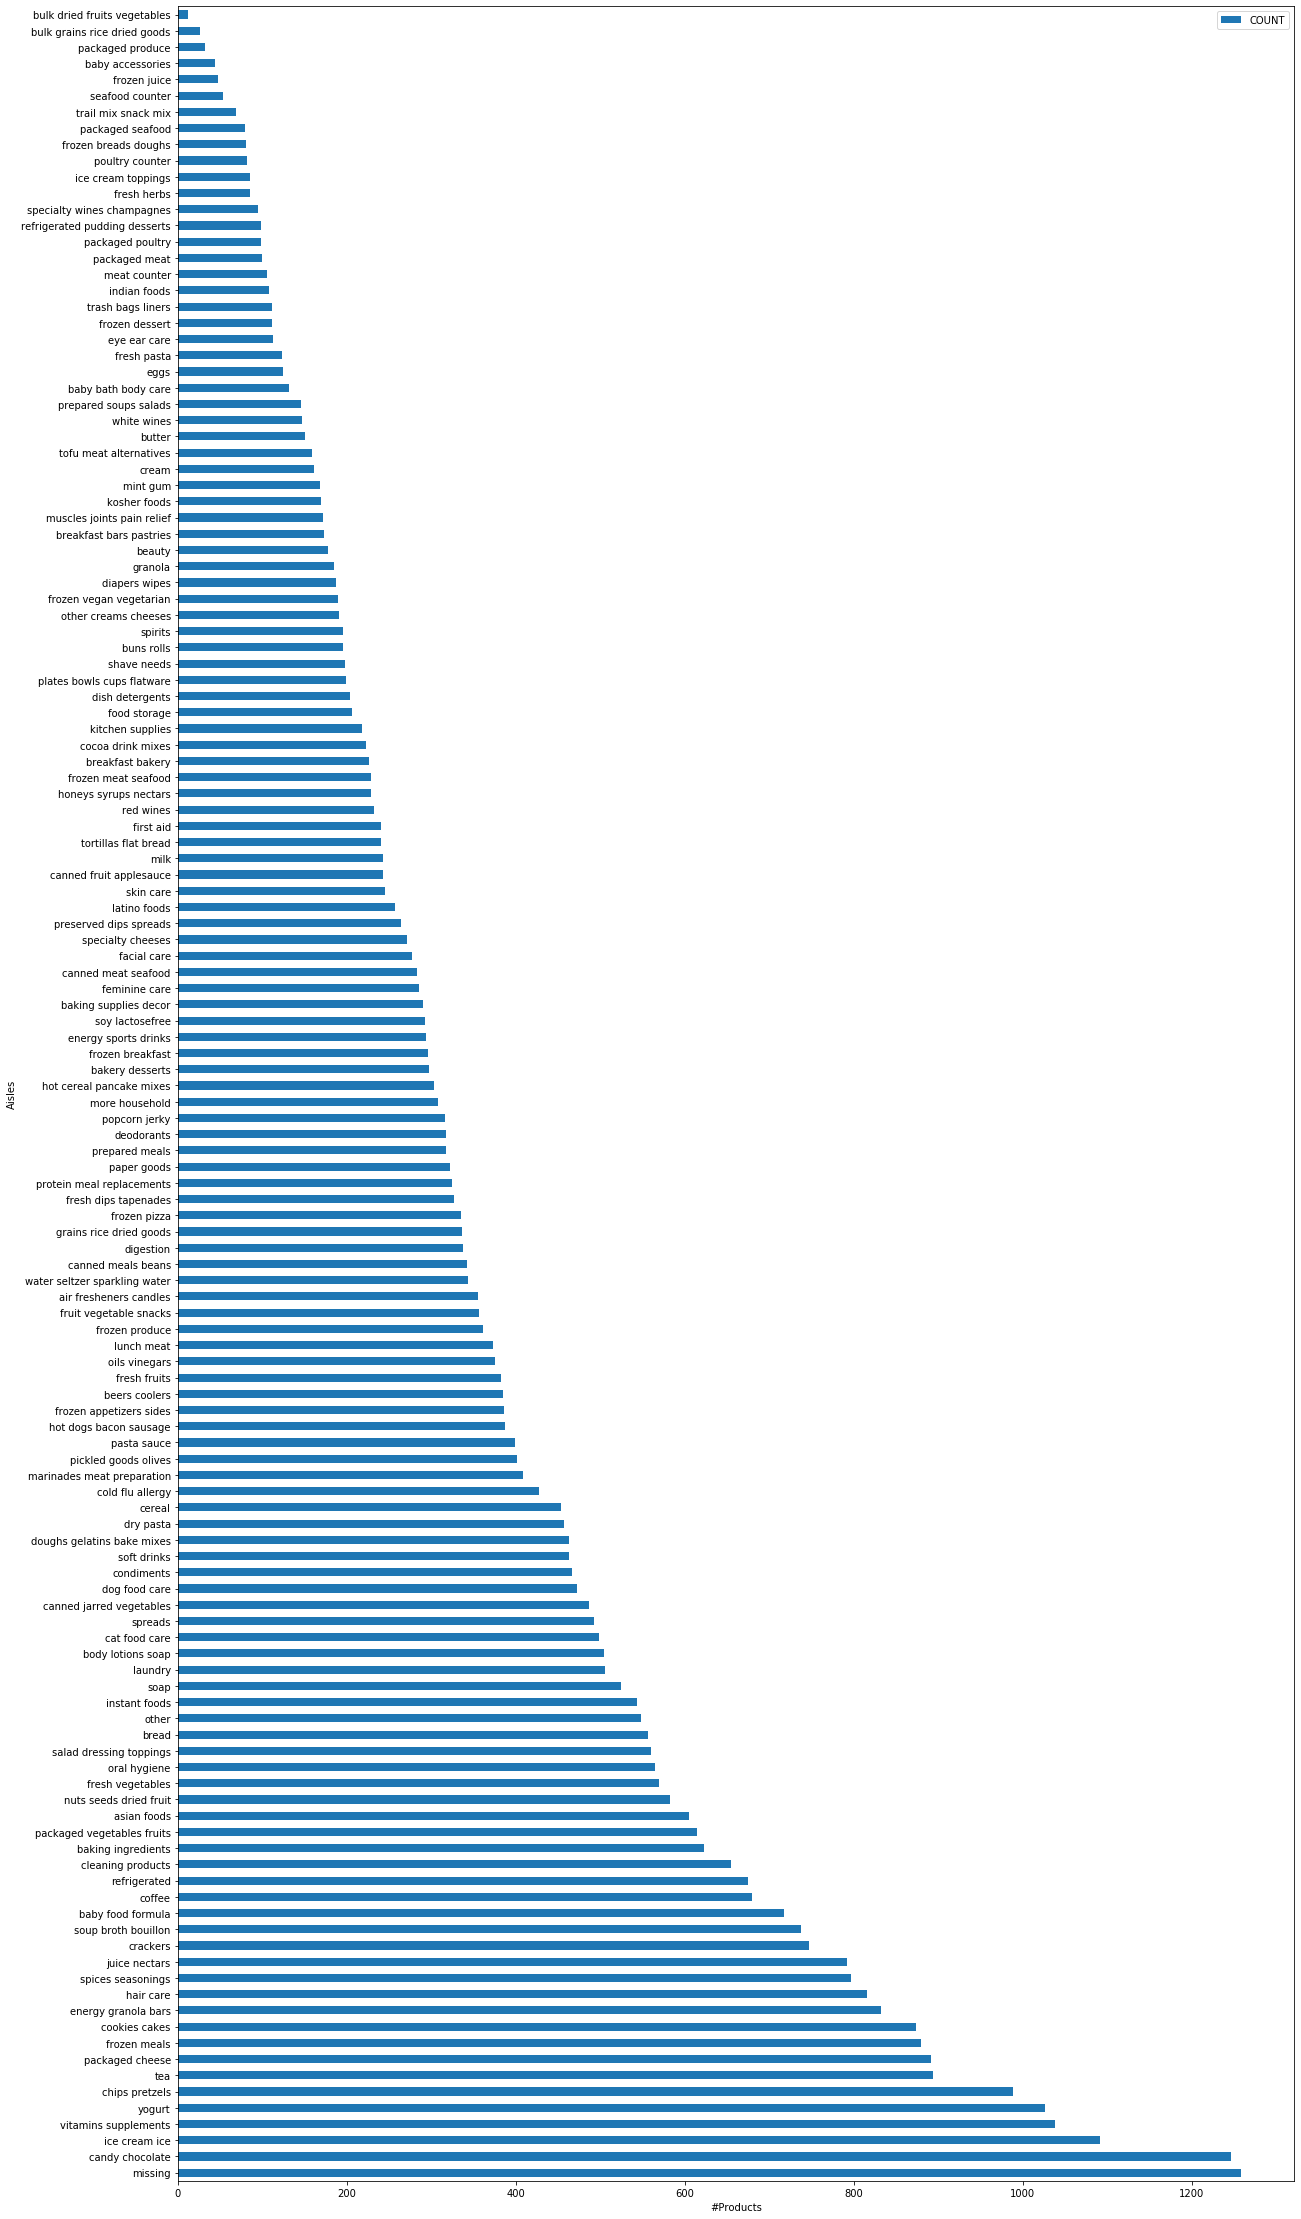

In [22]:
ax = per_aisle.plot(kind='barh', figsize=(20,40))
ax.set_xlabel('#Products')
ax.set_ylabel('Aisles')
plt.show()

In [23]:
per_aisle.head()

,COUNT
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026


'Candy chocolate' and 'ice cream ice' have the largest choices of products. We can see that none of the 10 first aisles are in the 'Personal care' departement. However, this department is the lagest in terms of products number because it offers a diverse choice of aisles instead of one aisle with many products, as 'Snacks'.

### Number of orders

Let's complete our 'useful' dataset with the information about the number of orders per product

In [24]:
number_of_order_per_product = history[['order_id','product_id']].groupby('product_id').count().sort_values(by='order_id', ascending=False)
number_of_order_per_product = number_of_order_per_product.rename(columns={"order_id" : "number_of_orders"})
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [25]:
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [26]:
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [27]:
products_litteral = pd.merge(products_litteral, number_of_order_per_product, on='product_id')
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


**Number of orders per product**

In [28]:
products_litteral.sort_values(by='number_of_orders', ascending=False).head()

,product_id,product_name,aisle,department,number_of_orders
42491,24852,Banana,fresh fruits,produce,472565
42399,13176,Bag of Organic Bananas,fresh fruits,produce,379450
42466,21137,Organic Strawberries,fresh fruits,produce,264683
41417,21903,Organic Baby Spinach,packaged vegetables fruits,produce,241921
42662,47209,Organic Hass Avocado,fresh fruits,produce,213584


Bananas are the most sold product.

Text(0.5, 0, 'Departments')

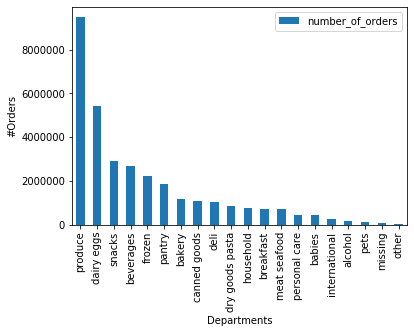

In [29]:
order_by_department = products_litteral[['department', 'number_of_orders']].groupby('department').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_department.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Departments')

Text(0.5, 0, 'Aisles')

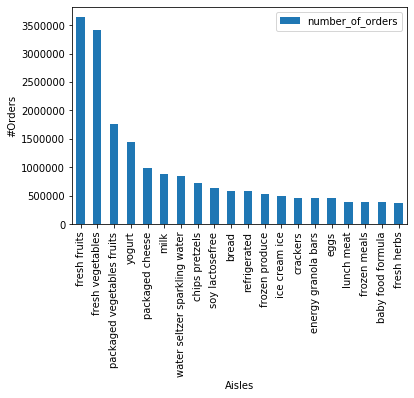

In [30]:
order_by_aisle = products_litteral[['aisle', 'number_of_orders']].groupby('aisle').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_aisle.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Aisles')

Produce, followed by eggs are the departments with most sales. For the aisles, it is fresh fruits and vegetables that take the lead. Interestingly, snacks, which is the aisle with mostthe largest choice of products, is only the third in number of sales.

### Timing of orders

In [31]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [32]:
days_of_orders = orders[['order_id', 'order_dow']].groupby('order_dow').count()
days_of_orders = days_of_orders.rename(columns={"order_id" : "number_of_orders"})
days_of_orders

,number_of_orders
order_dow,
0,600905
1,587478
2,467260
3,436972
4,426339
5,453368
6,448761


In [33]:
days_of_orders.index = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

We found in some metadata that 0 corresponds to Saturday. This is not surprising as we expect that customers have more time to purchase during weekends.

Text(0, 0.5, '#Orders')

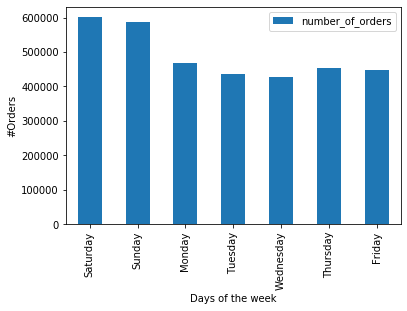

In [34]:
ax = days_of_orders.plot(kind='bar')
ax.set_xlabel('Days of the week')
ax.set_ylabel('#Orders')

Text(0, 0.5, '#Orders')

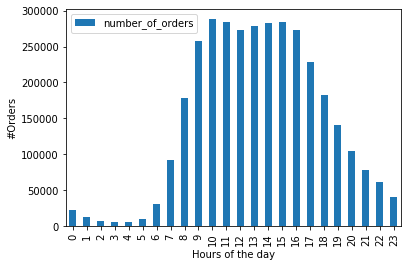

In [35]:
hours_of_orders = orders[['order_id', 'order_hour_of_day']].groupby('order_hour_of_day').count()
hours_of_orders = hours_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = hours_of_orders.plot(kind='bar')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('#Orders')

People tend to order during working hours (between 8 a.m. and 20 p.m.), and at the beginning of the week (Monday and Tuesday).

### Multiple orders

Text(0, 0.5, '#of such orders')

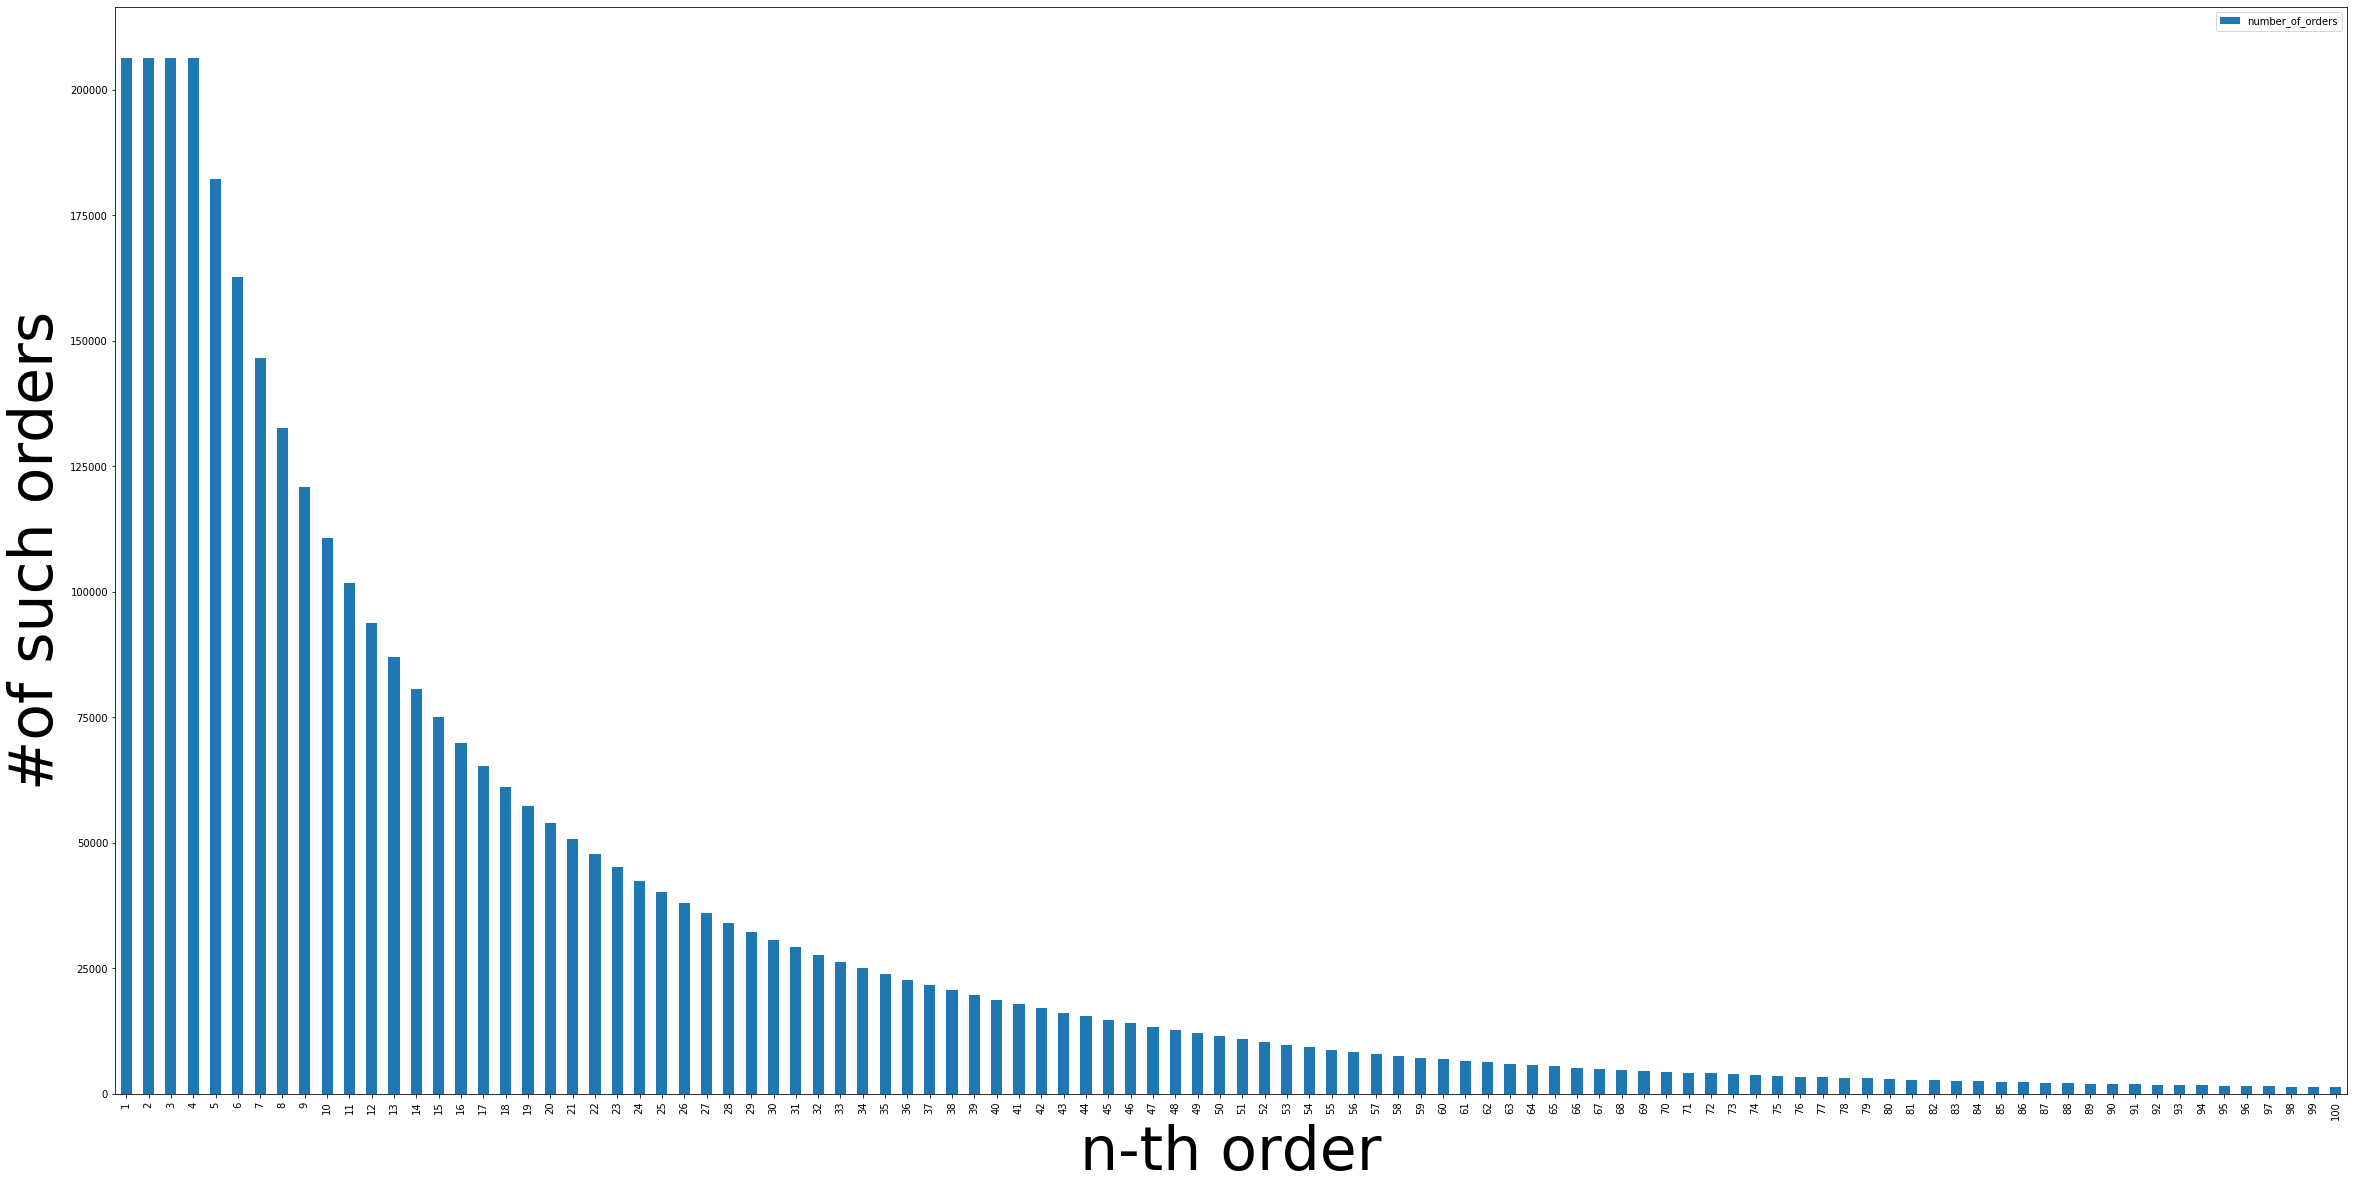

In [36]:
number_of_orders = orders[['order_id', 'order_number']].groupby('order_number').count() #Order_number represents the number of the order with respect to a particular customer
number_of_orders = number_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = number_of_orders.plot(kind='bar', figsize=(40,20))
ax.set_xlabel('n-th order',fontsize=60)
ax.set_ylabel('#of such orders',fontsize=60)

Most of the orders are first-time orders. We can see it from a different perspective with an user-centric approach.

In [37]:
max_orders = orders[['user_id', 'order_number']].groupby('user_id').max()
max_orders = max_orders.rename(columns={"order_number" : "max_orders"})

Text(0, 0.5, '#Users')

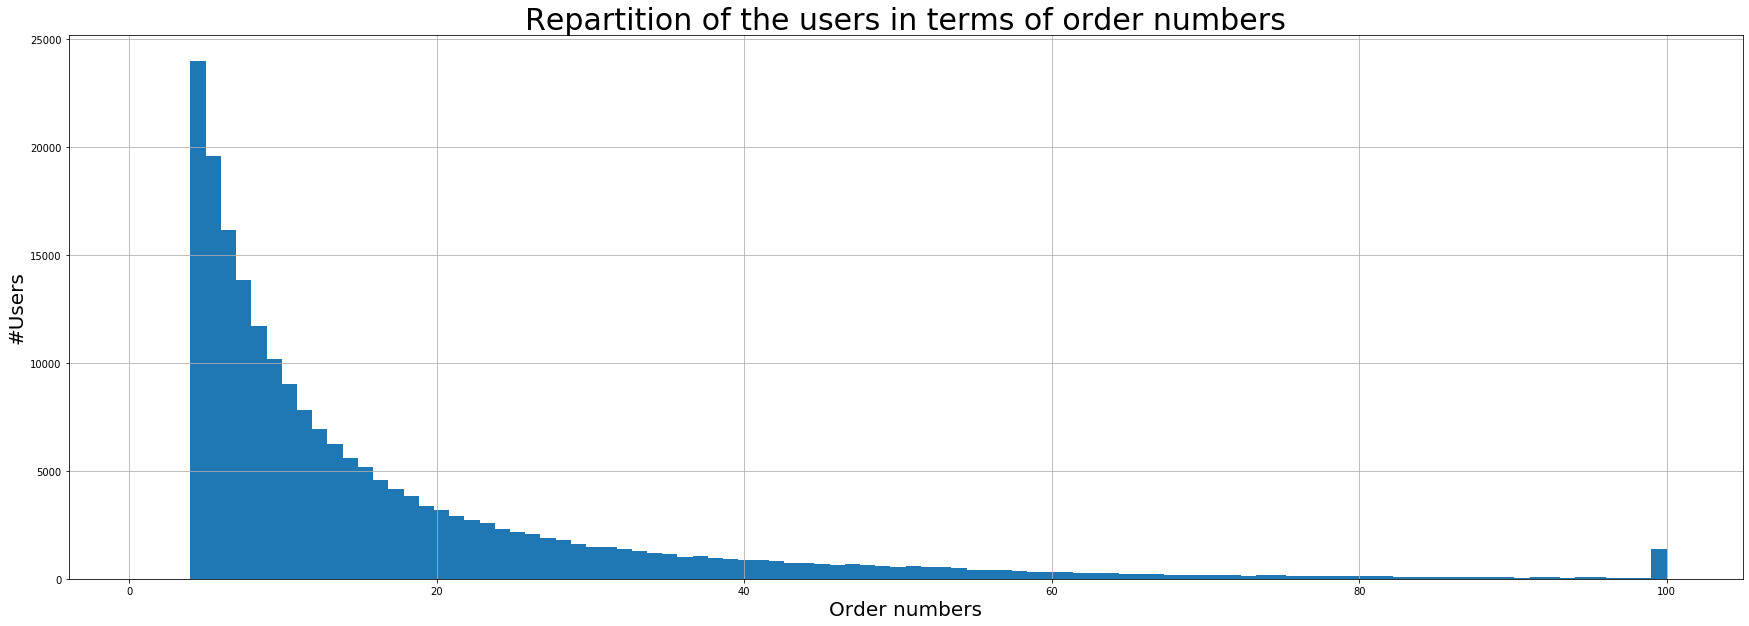

In [38]:
m = int(max_orders.max())
max_orders.hist(range=(1, m), bins = m, figsize=(30,10))
plt.title('Repartition of the users in terms of order numbers',fontsize=30)
plt.xlabel('Order numbers',fontsize=20)
plt.ylabel('#Users',fontsize=20)

Most of the consumers only order 4 times. None of them order less, which is surprising. We can hypothesize that we were provided with a dataset containing only user data , and the distribution is then logarithmic We can see a high pic at 100 orders, which probably correspond to "100 and more". 

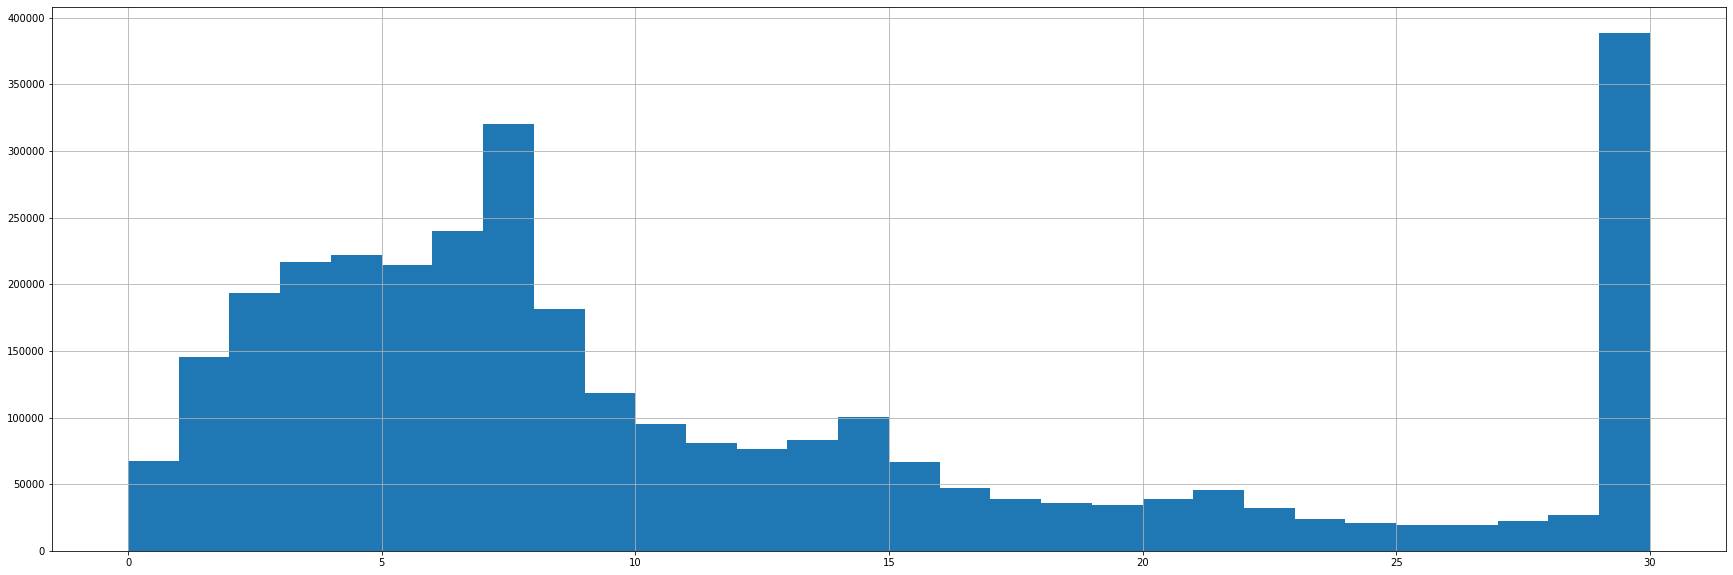

In [39]:
m = int(orders['days_since_prior_order'].max())
orders['days_since_prior_order'].hist(bins = m, figsize=(30,10))

We can see a high pick in "30 days", which probably corresponds to "30 and more", thus unregular users. Otherwise, most consumer reorder within 10 days and we can see a pick in 7 days. This means many users order at the same day of he week.

### Reordering

We finally want to merge our history and orders datasets to gather all informations about reordering. This is the final dataset we'll use.

In [40]:
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [41]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [42]:
history_users = pd.merge(history, orders, on='order_id')
history_users.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [43]:
history_users.to_pickle('history_users')

# Incorporate informations with the Amazon dataset

**Amazon dataset** : _metadata_ and _reviews_ of Grocery and Gourmet Food products : https://cseweb.ucsd.edu/~jmcauley/datasets.html?fbclid=IwAR39s5O83nqUYkRBD4jol3OFu0FmcH-4dCzUtSjutOsmSd9LMZOHSGGtNxw#amazon_reviews


To get some more qualitative informations on our Instacart products (e.g. price, quality, etc.), we tried to incorporate informations from the Amazon dataset. The only way that come to our mind to make this merge is to rely on product names. 

We have noticed that some Instacart product names are way too vague (e.g. "water") to be matched precisely to an Amazon product. Moreover, Instacart product names are more generally less precise than Amazon names, without mentionning the brand for instance. Therefore we cannot be sure to match identical products.

In order to match products as precisely as possible, we will match an Instacart product to an Amazon product if and only if:
* the Amazon name contains all the words of the Instacart name,
* only one Amazon product satisifes the previous condition (otherwise we suppose the Instacart name is too broad). 

In [44]:
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


In [45]:
# create Spark session
spark = sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
# read Amazon data
Amazon_meta = spark.read.json("data/meta_Grocery_and_Gourmet_Food.json.gz")
Amazon_meta.show(2)

In [51]:
# adn retain only useful columns
Amazon_meta_light = Amazon_meta.drop('also_view','description','details','feature','fit', 'image','similar_item', 'tech1')

In [52]:
Amazon_meta_light.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- title: string (nullable = true)



In [53]:
# use only a subset af Amazon dataset (for computational reasons), this needs to be changed
Amazon1=Amazon_meta_light.sample(False, 0.001)

In [54]:
Amazon1.count() #number of rows in this test sample Amazon dataset

311

In [55]:
# move Instacart data to Spark as well
products_lit_spark = spark.createDataFrame(products_litteral)#.limit(10000) #convert Instacart panda df to spark df
products_lit_spark = products_lit_spark.withColumn('product_name', F.regexp_replace('product_name', '\\\"', ''))
products_lit_spark = reload('products_lit_spark.parquet', products_lit_spark)

In [56]:
products_lit_spark.count()

49677

In [57]:
products_lit_spark.show()

+----------+--------------------+-----+----------+----------------+
|product_id|        product_name|aisle|department|number_of_orders|
+----------+--------------------+-----+----------+----------------+
|     36629|Lucky Irish Break...|  tea| beverages|               9|
|     36638|Scottish Breakfas...|  tea| beverages|              85|
|     36694|White Tea Unsweet...|  tea| beverages|              28|
|     36771|    Twig Kukicha Tea|  tea| beverages|              62|
|     36890|Healthy Cycle Her...|  tea| beverages|              18|
|     36891|Superfruit Pomegr...|  tea| beverages|               5|
|     36902|RX Stress Herbal ...|  tea| beverages|              22|
|     36951|   Organic White Tea|  tea| beverages|               6|
|     37071|Herbal Tea, Caffe...|  tea| beverages|              41|
|     37102|Honey Lemon Ginse...|  tea| beverages|              18|
|     37118|Peach, Natural Bl...|  tea| beverages|              24|
|     37154|Herbal Tea, Lemon...|  tea| beverage

In [60]:
# define a udf to return the set of words contained in a product name
words_udf = udf(lambda x: list(set(re.compile("\\W+").split(x))), sql.types.ArrayType(sql.types.StringType()))

In [61]:
# create the lists of words contained in the amazon product name ('title')
Amazon_title_as_words = Amazon1.withColumn('title_words', words_udf('title'))
print(Amazon_title_as_words.count())

# remove duplicates
Amazon_title_as_words = Amazon_title_as_words.withColumn('str_wds', F.col('title_words').cast('string'))
Amazon_title_as_words = Amazon_title_as_words.dropDuplicates(subset=['str_wds']).drop('str_wds')
print(Amazon_title_as_words.count())

Amazon_title_as_words = reload('Amazon_title_as_words.parquet', Amazon_title_as_words)
for row in Amazon_title_as_words.take(10):
    print(row.title_words)

311
311
['Bean', 'Java', 'Whole', 'Ounce', 'Coffee', '12', 'Christopher', 'Blend', 'Mocha']
['Peppers', 'Sansho', '0', 'Ounce', 'S', 'B', '42', 'Szechuan']
['Taco', '', '5', 'McCormick', 'Seasoning', 'Ounce', 'Pack', '12', '1', 'of', 'Mild']
['face', 'mobile', 'unifiedLocationMobileButton', '8D9096', 'circle', 'onLdEnd', 'dark', 'warning', 'sdCorner', '_RC', 'sdBuyBox', 'location', '38', 'recently_viewed_items4', '49px', 'capabilities', 'prefix', 'pwEligibleCityMobile', 'brief', 'p13n', 'bind', 'uei', 'subnav', 'buyboxShippingLabel', '2px', 'khtml', 'csm', '090', '2BAC2B', 'enabled', 'idden', '51WivJzk7vL', 'pull12', 'right', 'truncate', '81px', 'fefaf6', 'ue_swi', 'couponTable', '834', 'csxfs_selectedsample_image_container', 'cat', 'outset', '455px', 'null', '28867', 'bRecPlusContainer', 'ty', '92813', 'td', 'row', '385px', 'secondary', 'selected', 'rpl', '56', '280px', '75093', 'pull8', 'sdBoxBR', 'f7f8fa', 'gradient', 'normal', '283px', 'map', 'burjActionPanelDivider', 'bcc1c8', '47

In [62]:
# create the lists of words contained in the instacart product name ('title')
products_words = products_lit_spark.withColumn('name_words', words_udf('product_name'))
print(products_words.count())

# remove duplicates
products_words = products_words.withColumn('str_wds', F.col('name_words').cast('string'))
products_words = products_words.dropDuplicates(subset=['str_wds']).drop('str_wds')
print(products_words.count())

products_words.show(300)

49677
48339
+----------+--------------------+--------------------+---------------+----------------+--------------------+
|product_id|        product_name|               aisle|     department|number_of_orders|          name_words|
+----------+--------------------+--------------------+---------------+----------------+--------------------+
|     35417| Reduced Fat Milk 2%|                milk|     dairy eggs|            2268|[, Fat, 2, Milk, ...|
|     14214|Gentle Iron 28mg ...|vitamins supplements|  personal care|               7|g, Gentle, Ir...|
|     29847|Wrigley's 5 React...|            mint gum|         snacks|              18|[5, Mint, Unique,...|
|     42502|ProActive Health ...|       dog food care|           pets|             161|[Adult, Food, Pro...|
|     19942|Aged Balsamic Vin...|       oils vinegars|         pantry|              43|[Aged, Modena, Of...|
|      9960|Moving And Storag...|      more household|      household|              34|[And, Moving, Tap...|
|      3912

We consider that products whose name is only one word are not precise enough (eg 'Water').


In [63]:
# define udf to filter one-word product names
len_filter = udf(lambda x: len(x) <= 1, sql.types.BooleanType())

In [64]:
# keep only products whose name contains more than one word
real_products = products_words.filter(~len_filter('name_words'))
real_products = reload('real_products.parquet', real_products)
real_products.show()

+----------+--------------------+--------------------+---------------+----------------+--------------------+
|product_id|        product_name|               aisle|     department|number_of_orders|          name_words|
+----------+--------------------+--------------------+---------------+----------------+--------------------+
|     28726|Large Waterproof ...|           first aid|  personal care|              17|[, 2, Large, 7, W...|
|     32566|Dha Omega 3 Vitam...|                milk|     dairy eggs|            7751|[3, Vitamin, Dha,...|
|     22666|Cucumbers Facial ...|                soap|  personal care|             330|[30, Wipes, CT, C...|
|      7574|5 Cobalt Cooling ...|            mint gum|         snacks|             139|[5, Cooling, Suga...|
|     20248|5 oz All Purpose ...|plates bowls cups...|      household|             137|[5, Cups, All, Pu...|
|      4200|60 Watt Crystal C...|      more household|      household|               5|[60, Clear, Watt,...|
|     48861|Adult H

We explode the words contained in both the Instacart and Amazon datasets in order to join on identical words (the we have to group by same Instacart _and_ same amazon name).

In [67]:
Amazon_expl = Amazon_title_as_words.withColumn('title_word', F.explode('title_words').alias('title_word'))
Amazon_expl = reload('Amazon_expl.parquet', Amazon_expl)

In [68]:
products_expl = real_products.withColumn('name_word', F.explode('name_words').alias('name_word'))
products_expl = reload('products_expl.parquet', products_expl)

In [69]:
# join on identiacal words
df_withwords = Amazon_expl.join(products_expl, Amazon_expl.title_word==products_expl.name_word)
df_withwords = reload('df_withwords.parquet', df_withwords)
df_withwords.show()

+--------------------+----------+--------------------+--------------------+----+--------+-----+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+---------------+----------------+--------------------+---------+
|            also_buy|      asin|               brand|            category|date|main_cat|price|                rank|               title|         title_words|title_word|product_id|        product_name|               aisle|     department|number_of_orders|          name_words|name_word|
+--------------------+----------+--------------------+--------------------+----+--------+-----+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+---------------+----------------+--------------------+---------+
|[B00CM26YDQ, B00D...|B00CM26YM2|Christopher Bean ...|[Grocery & Gourme...|null| Grocery|$9.22|64,073inGroceryGo...|Christopher Bean ...|[B

In [70]:
# now group by both names and count words in common
regrouped = df_withwords.groupBy(['product_name', 'title']).agg(F.count('title_word').alias('nb_common_words'), F.collect_set('name_words').getItem(0).alias('name_words'))
regrouped = reload('regrouped.parquet', regrouped)
regrouped.show()

Py4JJavaError: An error occurred while calling o181.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:229)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:566)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 45.0 failed 1 times, most recent failure: Lost task 2.0 in stage 45.0 (TID 882, localhost, executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@1025b3b9 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:219)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:285)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:383)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertKVRecord(UnsafeExternalSorter.java:433)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.insertKV(UnsafeKVExternalSorter.java:183)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator.addInput(ObjectAggregationIterator.scala:231)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:192)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:78)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:105)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:167)
	... 33 more
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@1025b3b9 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:219)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:285)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:383)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertKVRecord(UnsafeExternalSorter.java:433)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.insertKV(UnsafeKVExternalSorter.java:183)
	at org.apache.spark.sql.execution.aggregate.SortBasedAggregator.addInput(ObjectAggregationIterator.scala:231)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:192)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:78)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec$$anonfun$doExecute$1$$anonfun$2.apply(ObjectHashAggregateExec.scala:105)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndexInternal$1$$anonfun$12.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
# this function tests whether all the words of the Instacart name are found in the Amazon name (i.e. the number of words in common is equal to the number of words of the Instacart name)
full_match_udf = udf(lambda nb, name_words: len(name_words)==nb, sql.types.BooleanType())

# keep only products whose Instacart name's words are all found in the Amazon name
full_match = regrouped.filter(full_match_udf('nb_common_words', 'name_words'))
full_match = reload('full_match.parquet', full_match)
full_match.show()
for row in full_match.take(100):
    print(row.product_name, ': ', row.title, '\n', row.name_words, ' |-| ', row.nb_common_words, '\n'+'_'*100+'\n')

In [ ]:
# now group by Instacart product and count the number of matching Amazon products
name_in_title = full_match.groupBy('product_name').agg(F.collect_list('title').alias('titles'), F.count('title').alias('nb_titles'))
name_in_title = reload('name_in_title.parquet', name_in_title)
name_in_title.show()
for row in name_in_title.take(100):
    print(row.product_name, ': ', row.titles, '\n')

In [ ]:
unique_match3 = name_in_title.filter(len_filter('titles'))
unique_match3 = reload('unique_match3.parquet', unique_match3)
for row in unique_match3.take(100):
    print(row.product_name, ': ', row.titles, '\n')

In [ ]:
real_products.count()

In [ ]:
unique_match3.count()

As stated above, we didn't manage to run this merge on our computers, as it requires too much memory. On a subset of both Dataframes (full Instacart, 10% of Amazon), we managed to have a match of 500 products that satisfy the constraints described above. Our goal is now to try to run this approach on the cluster. If it succeeds, we'll be able to have more insights about our products to determine customers behaviours. If not, we'll try to identify by hand "healthy" classes of products. 

# Analysis (indicative work plan)

Use clustering to distinguish different types of consumers, by point assignement with k-means method.

In [43]:
#Dataframe : rows = one by order and product ; columns : user, product, aisle, department ; group by users
#Features : products bought, with their aisle and department

In [44]:
from sklearn.cluster import KMeans

In [45]:
#train the kmeans with number of clusters k between 1 and 50
#Evaluate each one by computing 'silhouette' S. Choose optimal k corresponding to highest S

Manually label the clusters obtained, distinguishing them in a healthiness scale. Define the 'ideal consumer' type, people should tend to. List the most recurrent products, aisles and department in this 'ideal' group.

Get the consumption habits of this 'ideal' group : hour of day, day of week, time between orders, number of orders, rate of reordering 

Get a list of products that can be advised to the other groups, based on reordering.

In [46]:
#Design and add a field for each product, measuring its probability to be reordered
#Find the equivalent products between consumers group, based on aisles

Amazon dataset ? : find the average price of products by aisles. Then highlight the budget differences between the consumers groups, especially compared to the 'ideal' one.